# Compare model performances on heldout plate (Plate 3)

In this notebook, we apply both the final (all features) and supplemental (actin only features or without actin features) to the Plate 3 data and create a PR curve that compares the performance only on the DMSO (negative control) treated cells.

## Import libraries

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve, auc

sys.path.append("../../utils")
from eval_utils import generate_confusion_matrix_df, generate_f1_score_df
from training_utils import get_X_y_data

In [2]:
# Metadata column used for prediction class
label = "Metadata_cell_type"

# Directory with plate datasets
data_dir = pathlib.Path("../../3.process_cfret_features/data/single_cell_profiles")

# Directory for model figures output
fig_dir = pathlib.Path("./figures")
fig_dir.mkdir(exist_ok=True)

# Directory for probability data to be saved
prob_dir = pathlib.Path("./prob_data")
prob_dir.mkdir(exist_ok=True)

# Encoder path
encoder_path = pathlib.Path(
    "../0.train_logistic_regression/encoder_results/label_encoder_log_reg_fs_plate_4.joblib"
)

# Directory with models
models_dir = pathlib.Path("../0.train_logistic_regression/models")

# Find all .joblib files (including subfolders)
model_paths = list(models_dir.rglob("*.joblib"))

In [3]:
# Initialize the dictionary to store models
loaded_models = {}

# Loop through all .joblib files in the models directory (including subfolders)
for model_path in models_dir.rglob("*.joblib"):
    # Skip files with "no_QC" in the name
    if "no_QC" in model_path.name:
        continue

    # Initialize model_key variable
    model_key = None

    # Check if the file contains 'log_reg_fs_plate_4'
    if "log_reg_fs_plate_4" in model_path.name:
        # Set the model type to final or shuffled based on file name
        model_key = "allfeatures_" + (
            "final" if "final" in model_path.name else "shuffled"
        )

    # Check if the file contains 'actin' or 'rest'
    elif "actin" in model_path.name or "rest" in model_path.name:
        # Determine category (actin or rest) and type (final or shuffled)
        category = "actin" if "actin" in model_path.name else "rest"
        model_type = "final" if "final" in model_path.name else "shuffled"
        model_key = f"{category}_{model_type}"

    # If a valid model key was determined, load the model and add to dictionary
    if model_key:
        model = load(model_path)
        loaded_models.setdefault(model_key, []).append(
            {"model": model, "model_path": model_path}
        )
        print(f"Loaded model: {model_path.name} as {model_key}")

Loaded model: log_reg_fs_plate_4_shuffled_downsample.joblib as allfeatures_shuffled
Loaded model: log_reg_fs_plate_4_final_downsample.joblib as allfeatures_final
Loaded model: actin_shuffled_downsample.joblib as actin_shuffled
Loaded model: actin_final_downsample.joblib as actin_final
Loaded model: rest_shuffled_downsample.joblib as rest_shuffled
Loaded model: rest_final_downsample.joblib as rest_final


In [4]:
# Read metadata and filter columns directly in one step
model_column_names = [
    col
    for col in pq.read_metadata(
        f"{data_dir}/localhost231120090001_sc_feature_selected.parquet"
    ).schema.names
    if not col.startswith("Metadata_")
]

print(len(model_column_names))
# Print the first 5 column names
print(model_column_names[:5])

625
['Cytoplasm_AreaShape_BoundingBoxArea', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor']


In [5]:
# Load in plate 3 normalized data
plate_3_df = pd.read_parquet(f"{data_dir}/localhost230405150001_sc_normalized.parquet")

# Capitalize the cell type values
plate_3_df["Metadata_cell_type"] = plate_3_df["Metadata_cell_type"].str.capitalize()

# Extract metadata columns from the plate
metadata_columns = [col for col in plate_3_df.columns if col.startswith("Metadata_")]

# Extract feature columns that don't start with "Metadata_"
feature_columns = [col for col in plate_3_df.columns if not col.startswith("Metadata_")]

# Filter columns in data frame to only include those in the model
filtered_feature_columns = [
    col for col in plate_3_df.columns if col in model_column_names
]

# Filter the DataFrame to keep only the desired columns
plate_3_df = plate_3_df[metadata_columns + filtered_feature_columns].dropna(
    subset=model_column_names
)

# Output
print(plate_3_df["Metadata_treatment"].unique())
print(plate_3_df.shape)
plate_3_df.head()

['DMSO' 'drug_x' 'TGFRi']
(20861, 644)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,9,Failing,rejected,DMSO,221.046761,137.115493,246.602800,109.285755,...,-0.035117,-0.619206,-0.393448,0.938869,0.771698,0.406068,0.374039,-0.138748,-0.266794,-0.305486
1,B,2,9,Failing,rejected,DMSO,690.596142,183.067828,716.170091,177.132195,...,0.290339,-0.421502,-0.618520,0.198305,-0.199667,0.424753,0.323462,-0.219449,1.697858,-0.175679
2,B,2,9,Failing,rejected,DMSO,626.561490,206.923698,623.943740,199.906440,...,-0.319312,-0.627080,-0.213998,0.557294,0.715474,0.783465,0.531513,-0.126487,-0.242152,-0.312005
3,B,2,9,Failing,rejected,DMSO,559.448583,220.688160,528.646623,196.955552,...,0.817875,-0.410279,0.066951,0.279879,0.531243,0.697668,0.386800,-0.168629,-0.145371,-0.205381
4,B,2,9,Failing,rejected,DMSO,909.019946,247.694340,897.965996,253.621836,...,0.076669,0.784110,0.796587,-0.602722,-0.539279,0.971781,0.969710,-0.432344,-0.024062,-0.346036


In [6]:
# Filter the dataframe for rows where Metadata_treatment is DMSO
dmso_df = plate_3_df[plate_3_df["Metadata_treatment"] == "DMSO"]

# Count the occurrences of each Metadata_cell_type in the filtered dataframe
cell_type_counts = dmso_df["Metadata_cell_type"].value_counts()

# Display the counts
print(cell_type_counts)

Failing    9151
Healthy    1366
Name: Metadata_cell_type, dtype: int64


In [7]:
# Initialize empty lists to store data for each iteration
precision_list = []
recall_list = []
threshold_list = []
model_type_list = []
feature_set_list = []
treatment_list = []  # List for Metadata_treatment
cell_type_list = []  # List for Metadata_cell_type

# Loop through the dictionary of models (actin_final, actin_shuffled, etc.)
for category, models in loaded_models.items():
    # Extract model type from the category (actin_final -> final, actin_shuffled -> shuffled, etc.)
    model_type = category.split("_")[1]

    # Extract feature set from the first part of the category (actin or rest or allfeatures)
    feature_set = category.split("_")[0]

    # Iterate through each model in the current category (actin, rest, or allfeatures)
    for model_info in models:
        model = model_info["model"]  # Access the model object from the dictionary

        print(f"Evaluating {model_type} model in {category} category...")

        # Separate metadata columns
        metadata_columns = [
            col for col in plate_3_df.columns if col.startswith("Metadata_")
        ]

        # Separate features columns (filtering out features containing both "Correlation" and "Actin")
        filtered_columns = [
            col
            for col in plate_3_df.columns
            if not col.startswith("Metadata_")
            and not ("Actin" in col and "Correlation" in col)
        ]

        # Select feature columns based on the feature_set type
        if feature_set == "allfeatures":
            # For allfeatures, use all non-metadata columns (no filtering)
            features_columns = [
                col for col in plate_3_df.columns if not col.startswith("Metadata_")
            ]
        elif feature_set == "actin":
            features_columns = [col for col in filtered_columns if "Actin" in col]
        elif feature_set == "rest":
            features_columns = [col for col in filtered_columns if "Actin" not in col]
        else:
            raise ValueError(f"Unknown feature set: {feature_set}")

        # Create the new updated dataframe with the correct features
        updated_plate_3_df = plate_3_df[metadata_columns + features_columns]
        print(updated_plate_3_df.shape)

        # Get X and y data from the dataframe
        X, y = get_X_y_data(df=updated_plate_3_df, label=label, shuffle=False)

        # Load in label encoder
        le = load(encoder_path)

        # Assign y classes to correct binary using label encoder results
        y_binary = le.transform(y)

        # Predict class probabilities for morphology feature data
        predicted_probs = model.predict_proba(X)

        # Calculate the precision, recall data
        precision, recall, threshold = precision_recall_curve(
            y_binary, predicted_probs[:, -1]
        )
        threshold = np.append(threshold, np.nan)

        # Append data to lists
        precision_list.extend(precision.tolist())
        recall_list.extend(recall.tolist())
        threshold_list.extend(threshold.tolist())
        model_type_list.extend([model_type] * len(precision))
        feature_set_list.extend([feature_set] * len(precision))  # Append feature set

        # Add Metadata_treatment and Metadata_cell_type to the lists
        treatment_list.extend(plate_3_df["Metadata_treatment"].tolist())
        cell_type_list.extend(plate_3_df["Metadata_cell_type"].tolist())

# Ensure all lists are the same length before creating the DataFrame
min_length = min(
    len(precision_list),
    len(recall_list),
    len(threshold_list),
    len(model_type_list),
    len(feature_set_list),
    len(treatment_list),
    len(cell_type_list),
)

# Slice all lists to the same length
precision_list = precision_list[:min_length]
recall_list = recall_list[:min_length]
threshold_list = threshold_list[:min_length]
model_type_list = model_type_list[:min_length]
feature_set_list = feature_set_list[:min_length]
treatment_list = treatment_list[:min_length]
cell_type_list = cell_type_list[:min_length]

# Create a DataFrame from the accumulated data
pr_df = pd.DataFrame(
    {
        "Precision": precision_list,
        "Recall": recall_list,
        "Threshold": threshold_list,
        "Model_Type": model_type_list,
        "Feature_Set": feature_set_list,  # Include feature set
        "Metadata_Treatment": treatment_list,  # Include treatment
        "Metadata_Cell_Type": cell_type_list,  # Include cell type
    }
)

# Drop any NA data
pr_df.dropna(inplace=True)

# Show output of all data
print(pr_df.shape)
pr_df.head()

Evaluating shuffled model in allfeatures_shuffled category...
(20861, 644)
Evaluating final model in allfeatures_final category...
(20861, 644)
Evaluating shuffled model in actin_shuffled category...
(20861, 71)
Evaluating final model in actin_final category...
(20861, 71)
Evaluating shuffled model in rest_shuffled category...
(20861, 563)
Evaluating final model in rest_final category...
(20861, 563)
(125161, 7)


,Precision,Recall,Threshold,Model_Type,Feature_Set,Metadata_Treatment,Metadata_Cell_Type
0,0.205024,1.0,0.012550,shuffled,allfeatures,DMSO,Failing
1,0.205034,1.0,0.014076,shuffled,allfeatures,DMSO,Failing
2,0.205043,1.0,0.019792,shuffled,allfeatures,DMSO,Failing
3,0.205053,1.0,0.019884,shuffled,allfeatures,DMSO,Failing
4,0.205063,1.0,0.024067,shuffled,allfeatures,DMSO,Failing


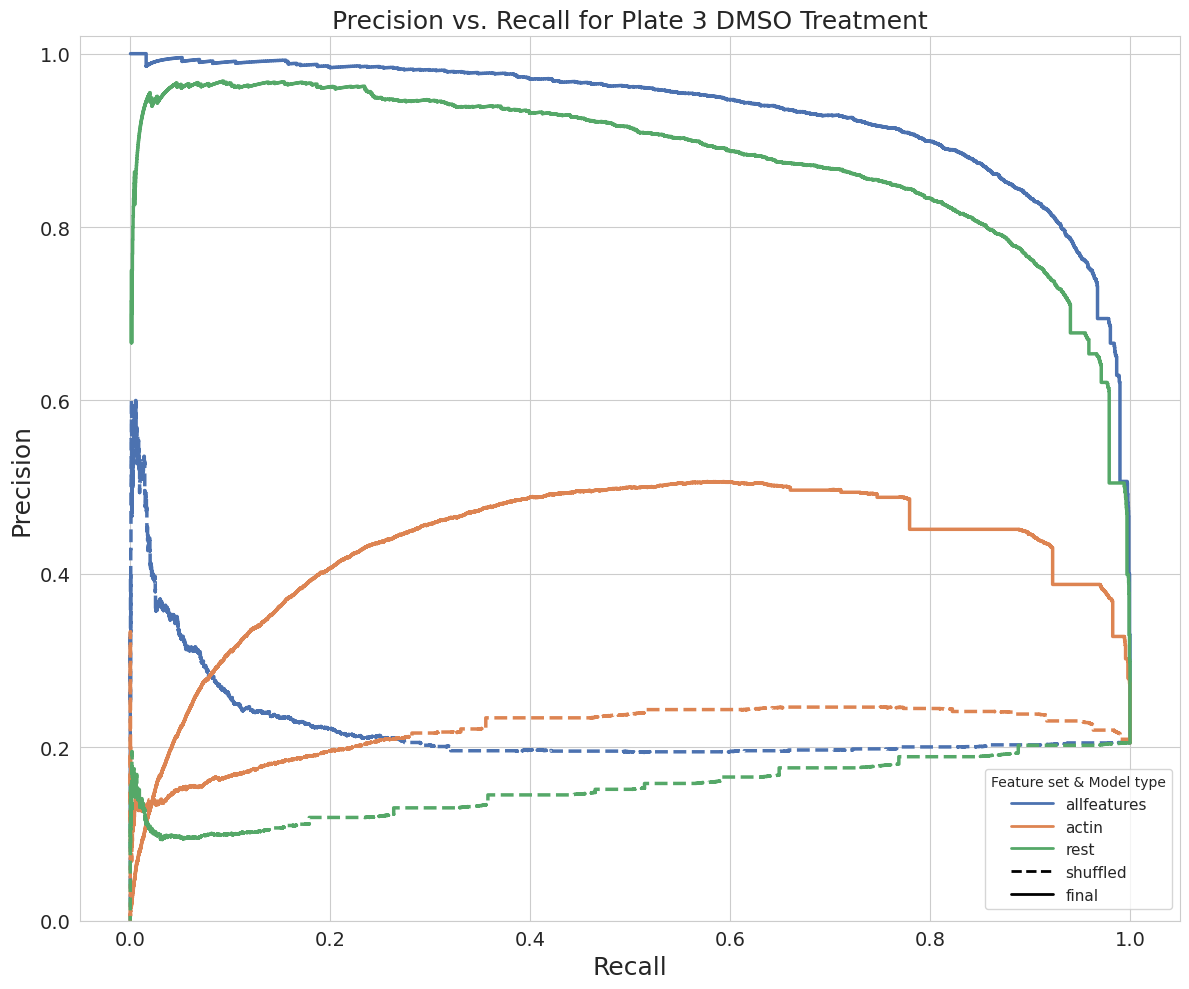

In [8]:
# Set figure size and Seaborn style
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Filter and prepare data for DMSO treatment
dmso_df = pr_df[pr_df["Metadata_Treatment"] == "DMSO"].copy()

# Unique feature sets and model types
feature_sets = dmso_df["Feature_Set"].unique()
model_types = dmso_df["Model_Type"].unique()

# Define line styles and Seaborn's default color palette
line_styles = {"final": "-", "shuffled": "--"}
colors = sns.color_palette("deep", n_colors=3)

# Plot Precision-Recall curves using plt.step
for idx, feature_set in enumerate(feature_sets):
    for model_type in model_types:
        subset = dmso_df[(dmso_df["Feature_Set"] == feature_set) & (dmso_df["Model_Type"] == model_type)]
        if not subset.empty:
            plt.step(
                subset["Recall"], subset["Precision"],
                where="post",
                label=f"{feature_set} ({model_type})",
                color=colors[idx % len(colors)],
                linestyle=line_styles[model_type], linewidth=2.5
            )

# Create custom legend handles for the Feature set (color) and Model type (line style)
color_handles = [Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=feature_set) 
                 for idx, feature_set in enumerate(feature_sets)]

line_handles = [Line2D([0], [0], color="black", lw=2, linestyle=line_styles[model_type], label=model_type) 
                for model_type in model_types]

# Combine the color and line style handles for the legend
all_handles = color_handles + line_handles

# Add the combined legend
plt.legend(
    handles=all_handles, loc="upper right", fontsize=11, title="Feature set & Model type",
    bbox_to_anchor=(1.0, 0.18), ncol=1, frameon=True, handlelength=2.8, handleheight=1.0
)

# Set axis labels, title, and formatting
plt.ylim(0.0, 1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall for Plate 3 DMSO Treatment", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate3_all_actin_rest.pdf", dpi=500)
plt.show()

In [9]:
# Filter the dataframe for the final rest features only model using the original pr_df
final_model_df = pr_df[
    (pr_df["Model_Type"] == "final") & (pr_df["Metadata_Treatment"] == "DMSO")
]

# Calculate AUPRC for all features data
allfeatures_data = final_model_df[final_model_df["Feature_Set"] == "allfeatures"]
allfeatures_auprc = auc(allfeatures_data["Recall"], allfeatures_data["Precision"])

# Calculate AUPRC for rest model
rest_data = final_model_df[final_model_df["Feature_Set"] == "rest"]
rest_auprc = auc(rest_data["Recall"], rest_data["Precision"])

# Calculate AUPRC for actin data
actin_data = final_model_df[final_model_df["Feature_Set"] == "actin"]
actin_auprc = auc(actin_data["Recall"], actin_data["Precision"])

# Output the results
print(f"AUPRC for All Features Model: {allfeatures_auprc:.4f}")
print(f"AUPRC for Rest Model: {rest_auprc:.4f}")
print(f"AUPRC for Actin Model: {actin_auprc:.4f}")

AUPRC for All Features Model: 0.9330
AUPRC for Rest Model: 0.8820
AUPRC for Actin Model: 0.4328
